In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import torch, numpy as np
from minai.core import *
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch import nn, tensor
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [3]:
torch.manual_seed(42)
np.random.seed(42)

## Prepare

In [4]:
model_id = 'meta-llama/Llama-2-7b-hf'
# model_id = 'gpt2-medium'
m = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [6]:
dataset = load_dataset("knowrohit07/know_sql", revision='f33425d13f9e8aab1b46fa945326e9356d6d5726', split="train")

In [7]:
def to_text(x):
    x['text'] = 'Context: ' + x['context'] + '\nQuestion: ' + x['question'] + '\nAnswer: ' + x['answer']
    # tokenize here?
    return x

def tok(x):
    x = tokenizer(x['text'], padding='longest')
    x['labels'] = deepcopy(x['input_ids'])
    return x

In [8]:
lf = nn.CrossEntropyLoss()

In [9]:
dataset = dataset.shuffle(42).map(to_text).filter(lambda x:len(x['text'])<380)

In [10]:
train_dataset = dataset.select(range(0, len(dataset)-200)) # Subset for testing
eval_dataset = dataset.select(range(len(dataset)-200, len(dataset))) # And only 200 eval samples
train_dataset

Dataset({
    features: ['context', 'answer', 'question', 'text'],
    num_rows: 76119
})

In [11]:
# Reorder by length

In [12]:
# Collate function for DataLoaders
def collate_fn(examples, debug=False):
    batch_size = len(examples)
    input_ids = tokenizer([e['text'] for e in examples], return_tensors='pt', padding=True)['input_ids']
    batch = (input_ids[:, :-1], input_ids[:, 1:]) # input_ids, labels
    # For HF style: batch = {'input_ids': input_ids[:, :-1], 'labels': input_ids[:, 1:]}
    return batch

In [13]:
batch_size = 64

In [14]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
)

In [15]:
eval_dataloader = DataLoader(
    eval_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
)

In [16]:
xb, yb = next(iter(train_dataloader))
xb.shape, yb.shape

(torch.Size([64, 115]), torch.Size([64, 115]))

In [17]:
tokenizer.decode(xb[0])[:250]

'<s> Context: CREATE TABLE table_name_74 (week VARCHAR, attendance INTEGER)\nQuestion: How many weeks had an attendance of over 68,000?\nAnswer: SELECT COUNT(week) FROM table_name_74 WHERE attendance > 68 OFFSET 000</s></s></s></s></s></s></s></s></s></'

In [18]:
tokenizer.decode(yb[0])[:250]

'Context: CREATE TABLE table_name_74 (week VARCHAR, attendance INTEGER)\nQuestion: How many weeks had an attendance of over 68,000?\nAnswer: SELECT COUNT(week) FROM table_name_74 WHERE attendance > 68 OFFSET 000</s></s></s></s></s></s></s></s></s></s></'

## Training

In [19]:
dls = DataLoaders(train_dataloader, eval_dataloader)

In [20]:
def loss_fn(x, y):
    return torch.nn.functional.cross_entropy(x.view(-1, x.shape[-1]), y.view(-1))

In [21]:
# from peft import get_peft_config, get_peft_model, LoraConfig, TaskType

# peft_config = LoraConfig(
#     task_type=TaskType.CAUSAL_LM, inference_mode=False, r=32, lora_alpha=16, lora_dropout=0.1,
#     target_modules=[l+"_proj" for l in ["k", 'v', "q", "o", "gate", "up", "down"]]
# )
# m = get_peft_model(m, peft_config)

In [22]:
from torch import optim

In [23]:
prog = ProgressCB(plot=True)
cbs = [DeviceCB(), MetricsCB()]

In [24]:
# Just freeze embeddings for small memory decrease
m.model.embed_tokens.weight.requires_grad_(False);

In [25]:
model_id = 'meta-llama/Llama-2-7b-hf'
# model_id = 'gpt2-medium'
m = AutoModelForCausalLM.from_pretrained(
    model_id,
    trust_remote_code=True,
    low_cpu_mem_usage=True,
    torch_dtype=torch.bfloat16,
    use_cache=False
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [26]:
# Or freeze first 8 layers for larger decrease. (Can freeze up to 31)
n_freeze = 8
for param in m.parameters(): param.requires_grad = False
for param in m.lm_head.parameters(): param.requires_grad = True
for param in m.model.layers[n_freeze:].parameters(): param.requires_grad = True

In [27]:
from functools import partial
optim = partial(torch.optim.Adam, betas=(0.9,0.99), eps=1e-5)

In [28]:
lr = 3e-3
sz = epoch_sz=len(dls.train)//5

In [29]:
cb_trn = TrainCB(preds_nm='logits')
learn = Learner(m, dls, loss_func=loss_fn, lr=lr, cbs=cbs+[cb_trn], epoch_sz=sz) #, opt_func=optim)

In [30]:
m.gradient_checkpointing_enable()

In [1]:
# NB lr_find does *not* reset model, so recreate it afterwards
# learn.lr_find(max_mult=10)

loss,epoch,train
0.655,0,train
0.636,0,eval


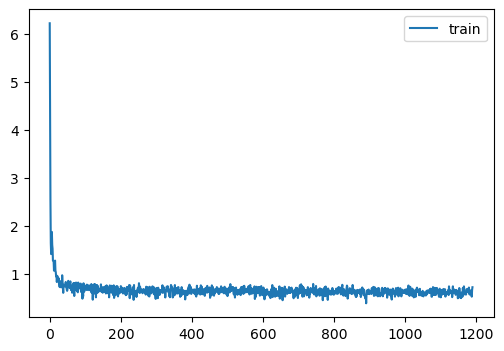

In [39]:
learn.fit(1, cbs=prog)

In [43]:
learn.model.save_pretrained('sql_1ep_636')

In [48]:
#SGD
torch.cuda.max_memory_allocated()/1_000_000_000

23.791612928

In [49]:
#adam
torch.cuda.max_memory_allocated()/1_000_000_000

44.16957184

## Testing

In [40]:
prompt = "Context:" + eval_dataset[0]['context'] + "\nQuestion:" + eval_dataset[0]['question'] + "\nAnswer:"
tokenized_prompt = tokenizer(prompt, return_tensors='pt')['input_ids'].cuda()

In [41]:
with torch.inference_mode():
    output = model.generate(tokenized_prompt, max_new_tokens=90)

In [42]:
print(prompt + tokenizer.decode(output[0][len(tokenized_prompt[0]):], skip_special_tokens=True))

Context:CREATE TABLE table_name_95 (tournament VARCHAR, score VARCHAR, outcome VARCHAR, surface VARCHAR)
Question:Which tournament has an Outcome of runner-up, a Surface of hard, and a Score of 6–4, 6–2?
Answer:SELECT tournament FROM table_name_95 WHERE outcome = "runner-up" AND surface = "hard" AND score = "6–4, 6–2"


## fin -